In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [3]:
train_dir = "../dataset/train"
test_dir = "../dataset/test"

In [4]:
# ============================================
# GESTION DES DOUBLONS ENTRE TRAIN ET TEST
# ============================================
import hashlib
from collections import defaultdict

def get_file_hash(file_path):
    """Calcule le hash MD5 d'un fichier"""
    hash_md5 = hashlib.md5()
    try:
        with open(file_path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    except Exception as e:
        print(f"Erreur lors du calcul du hash pour {file_path}: {e}")
        return None

# Liste des émotions (sous-dossiers)
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def get_file_hash_fast(file_path):
    """Calcule le hash MD5 d'un fichier (version optimisée avec chunks plus grands)"""
    hash_md5 = hashlib.md5()
    try:
        with open(file_path, "rb") as f:
            for chunk in iter(lambda: f.read(65536), b""):  # 64KB chunks (plus rapide)
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    except Exception as e:
        return None

def find_duplicates(train_dir, test_dir, remove_from_test=True):
    """
    Détecte et supprime les doublons entre train et test (VERSION OPTIMISÉE)
    
    IMPORTANT: Seuls les fichiers avec le MÊME CONTENU (même hash) sont considérés comme doublons.
    Les fichiers avec le même nom mais contenu différent ne sont PAS supprimés.
    
    Stratégie d'optimisation:
    1. Filtre par taille de fichier (RAPIDE - réduit le nombre de candidats)
    2. Vérifie par hash MD5 (PRÉCIS - seule méthode de confirmation)
    
    Args:
        train_dir: Dossier d'entraînement
        test_dir: Dossier de test
        remove_from_test: Si True, supprime les doublons du test (recommandé)
    """
    print("🔍 Recherche des vrais doublons entre train et test...")
    print("   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront supprimés")
    print("   (Méthode: taille → hash MD5 pour confirmation)")
    
    train_path = Path(train_dir)
    test_path = Path(test_dir)
    
    if not train_path.exists():
        print(f"❌ Dossier train introuvable: {train_dir}")
        return []
    if not test_path.exists():
        print(f"❌ Dossier test introuvable: {test_dir}")
        return []
    
    # Étape 1: Collecter tous les fichiers par nom (pour statistiques)
    print("\n⚡ Étape 1: Collecte des fichiers...")
    train_files_by_name = defaultdict(list)
    test_files_by_name = defaultdict(list)
    
    for emotion in EMOTIONS:
        train_emotion_dir = train_path / emotion
        test_emotion_dir = test_path / emotion
        
        if train_emotion_dir.exists():
            for img_file in list(train_emotion_dir.glob("*.jpg")) + list(train_emotion_dir.glob("*.png")):
                train_files_by_name[img_file.name].append(img_file)
        
        if test_emotion_dir.exists():
            for img_file in list(test_emotion_dir.glob("*.jpg")) + list(test_emotion_dir.glob("*.png")):
                test_files_by_name[img_file.name].append(img_file)
    
    # Statistiques sur les noms similaires (information uniquement)
    potential_by_name = 0
    for filename in test_files_by_name:
        if filename in train_files_by_name:
            potential_by_name += len(test_files_by_name[filename]) * len(train_files_by_name[filename])
    
    print(f"   📋 {potential_by_name} paires avec même nom (à vérifier par hash)")
    
    # Étape 2: Comparaison par taille pour optimiser (filtre rapide)
    print("\n⚡ Étape 2: Filtrage par taille de fichier...")
    
    # Grouper tous les fichiers par taille
    train_files_by_size = defaultdict(list)
    test_files_by_size = defaultdict(list)
    
    for files_list in train_files_by_name.values():
        for img_file in files_list:
            try:
                size = img_file.stat().st_size
                train_files_by_size[size].append(img_file)
            except:
                pass
    
    for files_list in test_files_by_name.values():
        for img_file in files_list:
            try:
                size = img_file.stat().st_size
                test_files_by_size[size].append(img_file)
            except:
                pass
    
    # Candidats pour vérification par hash (même taille)
    candidates_for_hash = []
    for size in test_files_by_size:
        if size in train_files_by_size:
            for test_file in test_files_by_size[size]:
                for train_file in train_files_by_size[size]:
                    candidates_for_hash.append((train_file, test_file))
    
    print(f"   📋 {len(candidates_for_hash)} candidats à vérifier par hash (même taille)...")
    
    # Étape 3: Vérification par hash (SEULE MÉTHODE DE CONFIRMATION)
    # On vérifie par hash TOUS les candidats, même ceux avec le même nom
    # car les noms peuvent se dupliquer sans que les fichiers soient identiques
    print("\n⚡ Étape 3: Vérification par hash (confirmation des vrais doublons)...")
    print("   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront considérés comme doublons")
    
    duplicates_confirmed = []  # Seuls les vrais doublons (même hash)
    checked = 0
    
    for train_file, test_file in candidates_for_hash:
        checked += 1
        if checked % 1000 == 0:
            print(f"   Progression: {checked}/{len(candidates_for_hash)} vérifiés...")
        
        train_hash = get_file_hash_fast(train_file)
        test_hash = get_file_hash_fast(test_file)
        
        if train_hash and test_hash and train_hash == test_hash:
            duplicates_confirmed.append({
                'train_file': train_file,
                'test_file': test_file,
                'hash': train_hash
            })
    
    print(f"   ✅ {len(duplicates_confirmed)} vrais doublons confirmés (même contenu)")
    
    total_train = sum(len(files) for files in train_files_by_name.values())
    total_test = sum(len(files) for files in test_files_by_name.values())
    
    print(f"\n📊 Statistiques finales:")
    print(f"   - Fichiers dans train: {total_train}")
    print(f"   - Fichiers dans test: {total_test}")
    print(f"   - Paires avec même nom: {potential_by_name} (information)")
    print(f"   - Vrais doublons confirmés (même contenu): {len(duplicates_confirmed)}")
    
    if len(duplicates_confirmed) == 0:
        print("\n✅ Aucun doublon détecté (fichiers avec contenu identique)!")
        return []
    
    # Afficher quelques exemples
    print(f"\n📋 Exemples de vrais doublons (premiers 5):")
    for i, dup in enumerate(duplicates_confirmed[:5]):
        print(f"   {i+1}. Train: {dup['train_file'].name} | Test: {dup['test_file'].name}")
        print(f"       Hash: {dup['hash'][:16]}...")
    
    if len(duplicates_confirmed) > 5:
        print(f"   ... et {len(duplicates_confirmed) - 5} autres")
    
    # Supprimer UNIQUEMENT les vrais doublons (confirmés par hash)
    if remove_from_test:
        print(f"\n🗑️  Suppression des {len(duplicates_confirmed)} vrais doublons du dossier test...")
        print("   (Seuls les fichiers avec le MÊME CONTENU sont supprimés)")
        removed_count = 0
        removed_files = set()  # Pour éviter les suppressions multiples
        
        for dup in duplicates_confirmed:
            test_file = dup['test_file']
            # Vérifier que le fichier existe et n'a pas déjà été supprimé
            if test_file.exists() and str(test_file) not in removed_files:
                try:
                    test_file.unlink()  # Supprime le fichier
                    removed_files.add(str(test_file))
                    removed_count += 1
                except Exception as e:
                    print(f"   ⚠️ Erreur lors de la suppression de {test_file.name}: {e}")
        
        print(f"✅ {removed_count} fichiers supprimés du test")
        print(f"   - Fichiers restants dans test: {total_test - removed_count}")
    else:
        print("\n⚠️ Suppression désactivée. Les doublons sont conservés.")
        print("   Pour supprimer, exécutez: find_duplicates(train_dir, test_dir, remove_from_test=True)")
    
    return duplicates_confirmed

# Exécuter la détection et suppression des doublons
# Décommentez la ligne suivante pour activer la suppression automatique
find_duplicates(train_dir, test_dir, remove_from_test=True)


🔍 Recherche des vrais doublons entre train et test...
   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront supprimés
   (Méthode: taille → hash MD5 pour confirmation)

⚡ Étape 1: Collecte des fichiers...
   📋 25874 paires avec même nom (à vérifier par hash)

⚡ Étape 2: Filtrage par taille de fichier...
   📋 275159 candidats à vérifier par hash (même taille)...

⚡ Étape 3: Vérification par hash (confirmation des vrais doublons)...
   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront considérés comme doublons
   Progression: 1000/275159 vérifiés...
   Progression: 2000/275159 vérifiés...
   Progression: 3000/275159 vérifiés...
   Progression: 4000/275159 vérifiés...
   Progression: 5000/275159 vérifiés...
   Progression: 6000/275159 vérifiés...
   Progression: 7000/275159 vérifiés...
   Progression: 8000/275159 vérifiés...
   Progression: 9000/275159 vérifiés...
   Progression: 10000/275159 vérifiés...
   Progression: 11000/275159 vérifiés...
   Progression: 12000/275159 vérifiés...
  

[]

In [ ]:
# Exécuter la détection RAPIDE des doublons (sans suppression)
print("=" * 60)
print("DÉTECTION RAPIDE DES DOUBLONS (Mode analyse uniquement)")
print("=" * 60)
duplicates = find_duplicates(train_dir, test_dir, remove_from_test=True)

# Pour supprimer les doublons, décommentez la ligne suivante:
find_duplicates(train_dir, test_dir, remove_from_test=True)


DÉTECTION RAPIDE DES DOUBLONS (Mode analyse uniquement)
🔍 Recherche des vrais doublons entre train et test...
   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront supprimés
   (Méthode: taille → hash MD5 pour confirmation)

⚡ Étape 1: Collecte des fichiers...
   📋 25874 paires avec même nom (à vérifier par hash)

⚡ Étape 2: Filtrage par taille de fichier...
   📋 275159 candidats à vérifier par hash (même taille)...

⚡ Étape 3: Vérification par hash (confirmation des vrais doublons)...
   ⚠️  Seuls les fichiers avec le MÊME CONTENU seront considérés comme doublons
   Progression: 1000/275159 vérifiés...
   Progression: 2000/275159 vérifiés...
   Progression: 3000/275159 vérifiés...
   Progression: 4000/275159 vérifiés...
   Progression: 5000/275159 vérifiés...
   Progression: 6000/275159 vérifiés...
   Progression: 7000/275159 vérifiés...
   Progression: 8000/275159 vérifiés...
   Progression: 9000/275159 vérifiés...
   Progression: 10000/275159 vérifiés...
   Progression: 11000/275159

[]

In [6]:
# ============================================
# FONCTION EXHAUSTIVE DE DÉTECTION DE DOUBLONS
# ============================================
import hashlib
from collections import defaultdict
import json
from datetime import datetime

def find_all_duplicates_exhaustive(train_dir, test_dir, 
                                     check_train_internal=True,
                                     check_test_internal=True,
                                     check_cross=True,
                                     remove_duplicates=False,
                                     remove_from='test',
                                     export_report=False):
    """
    Fonction EXHAUSTIVE pour détecter TOUS les doublons possibles
    
    Détecte:
    1. Doublons à l'intérieur du dossier train
    2. Doublons à l'intérieur du dossier test
    3. Doublons entre train et test
    
    Args:
        train_dir: Dossier d'entraînement
        test_dir: Dossier de test
        check_train_internal: Vérifier les doublons dans train
        check_test_internal: Vérifier les doublons dans test
        check_cross: Vérifier les doublons entre train et test
        remove_duplicates: Si True, supprime les doublons
        remove_from: 'test', 'train', ou 'both' - d'où supprimer
        export_report: Si True, exporte un rapport JSON
    
    Returns:
        dict: Rapport complet avec tous les doublons trouvés
    """
    print("=" * 80)
    print("🔍 ANALYSE EXHAUSTIVE DES DOUBLONS")
    print("=" * 80)
    print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print()
    
    train_path = Path(train_dir)
    test_path = Path(test_dir)
    
    if not train_path.exists():
        print(f"❌ Dossier train introuvable: {train_dir}")
        return None
    if not test_path.exists():
        print(f"❌ Dossier test introuvable: {test_dir}")
        return None
    
    # ============================================
    # ÉTAPE 1: COLLECTE DE TOUS LES FICHIERS
    # ============================================
    print("📂 Étape 1: Collecte de tous les fichiers...")
    
    train_files = {}  # {hash: [list of files]}
    test_files = {}   # {hash: [list of files]}
    
    # Collecter les fichiers train
    train_file_list = []
    for emotion in EMOTIONS:
        emotion_dir = train_path / emotion
        if emotion_dir.exists():
            for img_file in list(emotion_dir.glob("*.jpg")) + list(emotion_dir.glob("*.png")):
                train_file_list.append(img_file)
    
    # Collecter les fichiers test
    test_file_list = []
    for emotion in EMOTIONS:
        emotion_dir = test_path / emotion
        if emotion_dir.exists():
            for img_file in list(emotion_dir.glob("*.jpg")) + list(emotion_dir.glob("*.png")):
                test_file_list.append(img_file)
    
    print(f"   ✅ {len(train_file_list)} fichiers dans train")
    print(f"   ✅ {len(test_file_list)} fichiers dans test")
    
    # ============================================
    # ÉTAPE 2: CALCUL DES HASH (avec progression)
    # ============================================
    print("\n⚡ Étape 2: Calcul des hash MD5...")
    
    def calculate_hashes_batch(file_list, label):
        """Calcule les hashs pour une liste de fichiers"""
        file_hash_map = {}  # {file_path: hash}
        hash_to_files = defaultdict(list)  # {hash: [files]}
        
        total = len(file_list)
        for i, img_file in enumerate(file_list):
            if (i + 1) % 500 == 0 or i == 0:
                print(f"   {label}: {i+1}/{total} fichiers traités...")
            
            file_hash = get_file_hash_fast(img_file)
            if file_hash:
                file_hash_map[img_file] = file_hash
                hash_to_files[file_hash].append(img_file)
        
        print(f"   ✅ {label}: {total} fichiers traités")
        return file_hash_map, hash_to_files
    
    train_hash_map, train_hash_to_files = calculate_hashes_batch(train_file_list, "Train")
    test_hash_map, test_hash_to_files = calculate_hashes_batch(test_file_list, "Test")
    
    # ============================================
    # ÉTAPE 3: DÉTECTION DES DOUBLONS
    # ============================================
    print("\n🔍 Étape 3: Détection des doublons...")
    
    report = {
        'timestamp': datetime.now().isoformat(),
        'train_dir': str(train_dir),
        'test_dir': str(test_dir),
        'train_internal_duplicates': [],
        'test_internal_duplicates': [],
        'cross_duplicates': [],
        'statistics': {}
    }
    
    # 3.1 Doublons dans train (interne)
    if check_train_internal:
        print("\n   📊 Analyse des doublons dans TRAIN...")
        train_internal = []
        for file_hash, files in train_hash_to_files.items():
            if len(files) > 1:
                train_internal.append({
                    'hash': file_hash,
                    'count': len(files),
                    'files': [str(f) for f in files],
                    'emotions': [f.parent.name for f in files]
                })
        report['train_internal_duplicates'] = train_internal
        print(f"      ✅ {len(train_internal)} groupes de doublons trouvés dans train")
        if train_internal:
            total_dups = sum(d['count'] - 1 for d in train_internal)
            print(f"      📋 {total_dups} fichiers en doublon (peuvent être supprimés)")
    
    # 3.2 Doublons dans test (interne)
    if check_test_internal:
        print("\n   📊 Analyse des doublons dans TEST...")
        test_internal = []
        for file_hash, files in test_hash_to_files.items():
            if len(files) > 1:
                test_internal.append({
                    'hash': file_hash,
                    'count': len(files),
                    'files': [str(f) for f in files],
                    'emotions': [f.parent.name for f in files]
                })
        report['test_internal_duplicates'] = test_internal
        print(f"      ✅ {len(test_internal)} groupes de doublons trouvés dans test")
        if test_internal:
            total_dups = sum(d['count'] - 1 for d in test_internal)
            print(f"      📋 {total_dups} fichiers en doublon (peuvent être supprimés)")
    
    # 3.3 Doublons entre train et test
    if check_cross:
        print("\n   📊 Analyse des doublons entre TRAIN et TEST...")
        cross_duplicates = []
        for file_hash in train_hash_to_files:
            if file_hash in test_hash_to_files:
                train_files_list = train_hash_to_files[file_hash]
                test_files_list = test_hash_to_files[file_hash]
                
                for test_file in test_files_list:
                    cross_duplicates.append({
                        'hash': file_hash,
                        'train_file': str(train_files_list[0]),  # Prendre le premier
                        'test_file': str(test_file),
                        'train_emotion': train_files_list[0].parent.name,
                        'test_emotion': test_file.parent.name
                    })
        
        report['cross_duplicates'] = cross_duplicates
        print(f"      ✅ {len(cross_duplicates)} doublons trouvés entre train et test")
    
    # ============================================
    # ÉTAPE 4: STATISTIQUES DÉTAILLÉES
    # ============================================
    print("\n📊 Étape 4: Génération des statistiques...")
    
    stats = {
        'total_train_files': len(train_file_list),
        'total_test_files': len(test_file_list),
        'unique_train_files': len(train_hash_to_files),
        'unique_test_files': len(test_hash_to_files),
        'train_internal': {
            'duplicate_groups': len(report['train_internal_duplicates']),
            'duplicate_files': sum(d['count'] - 1 for d in report['train_internal_duplicates']),
            'space_wasted_mb': 0  # Sera calculé
        },
        'test_internal': {
            'duplicate_groups': len(report['test_internal_duplicates']),
            'duplicate_files': sum(d['count'] - 1 for d in report['test_internal_duplicates']),
            'space_wasted_mb': 0
        },
        'cross_duplicates': len(report['cross_duplicates'])
    }
    
    # Calculer l'espace gaspillé
    def calculate_wasted_space(duplicates_list):
        total_size = 0
        for dup_group in duplicates_list:
            if dup_group['files']:
                try:
                    file_size = Path(dup_group['files'][0]).stat().st_size
                    # Compter les fichiers en doublon (count - 1)
                    total_size += file_size * (dup_group['count'] - 1)
                except:
                    pass
        return total_size / (1024 * 1024)  # En MB
    
    stats['train_internal']['space_wasted_mb'] = calculate_wasted_space(report['train_internal_duplicates'])
    stats['test_internal']['space_wasted_mb'] = calculate_wasted_space(report['test_internal_duplicates'])
    
    report['statistics'] = stats
    
    # ============================================
    # ÉTAPE 5: AFFICHAGE DU RAPPORT
    # ============================================
    print("\n" + "=" * 80)
    print("📊 RAPPORT COMPLET DES DOUBLONS")
    print("=" * 80)
    print(f"\n📁 Fichiers:")
    print(f"   - Train: {stats['total_train_files']} fichiers ({stats['unique_train_files']} uniques)")
    print(f"   - Test: {stats['total_test_files']} fichiers ({stats['unique_test_files']} uniques)")
    
    if check_train_internal:
        print(f"\n🔍 Doublons dans TRAIN:")
        print(f"   - Groupes de doublons: {stats['train_internal']['duplicate_groups']}")
        print(f"   - Fichiers en doublon: {stats['train_internal']['duplicate_files']}")
        print(f"   - Espace gaspillé: {stats['train_internal']['space_wasted_mb']:.2f} MB")
    
    if check_test_internal:
        print(f"\n🔍 Doublons dans TEST:")
        print(f"   - Groupes de doublons: {stats['test_internal']['duplicate_groups']}")
        print(f"   - Fichiers en doublon: {stats['test_internal']['duplicate_files']}")
        print(f"   - Espace gaspillé: {stats['test_internal']['space_wasted_mb']:.2f} MB")
    
    if check_cross:
        print(f"\n🔍 Doublons entre TRAIN et TEST:")
        print(f"   - Nombre de doublons: {stats['cross_duplicates']}")
        if stats['cross_duplicates'] > 0:
            # Afficher quelques exemples
            print(f"\n   Exemples (premiers 5):")
            for i, dup in enumerate(report['cross_duplicates'][:5]):
                print(f"      {i+1}. Train: {Path(dup['train_file']).name} ({dup['train_emotion']})")
                print(f"         Test: {Path(dup['test_file']).name} ({dup['test_emotion']})")
    
    # ============================================
    # ÉTAPE 6: SUPPRESSION (si demandée) - VERSION SIMPLIFIÉE
    # ============================================
    if remove_duplicates:
        print("\n" + "=" * 80)
        print("🗑️  SUPPRESSION DES DOUBLONS")
        print("=" * 80)
        
        def delete_file(file_path_str):
            """Fonction simple pour supprimer un fichier"""
            try:
                # Convertir en Path et résoudre le chemin absolu
                file_path = Path(file_path_str).resolve()
                
                if not file_path.exists():
                    return False, f"Fichier introuvable: {file_path}"
                
                # Supprimer le fichier
                file_path.unlink()
                
                # Vérifier que la suppression a réussi
                if file_path.exists():
                    return False, f"Échec de la suppression: {file_path}"
                
                return True, "OK"
            except Exception as e:
                return False, f"Erreur: {e}"
        
        total_removed = 0
        
        # 1. Supprimer les doublons cross (train/test) du TEST
        if check_cross and remove_from in ['test', 'both']:
            print(f"\n🗑️  Suppression des doublons cross du TEST...")
            print(f"   {len(report['cross_duplicates'])} fichiers à supprimer")
            
            count = 0
            for dup in report['cross_duplicates']:
                success, msg = delete_file(dup['test_file'])
                if success:
                    count += 1
                    total_removed += 1
                elif "introuvable" not in msg.lower():
                    print(f"   ⚠️ {Path(dup['test_file']).name}: {msg}")
            
            print(f"   ✅ {count} fichiers supprimés")
        
        # 2. Supprimer les doublons internes du TEST
        if check_test_internal and remove_from in ['test', 'both']:
            print(f"\n🗑️  Suppression des doublons internes du TEST...")
            
            count = 0
            for dup_group in report['test_internal_duplicates']:
                # Garder le premier, supprimer les autres
                for file_path_str in dup_group['files'][1:]:
                    success, msg = delete_file(file_path_str)
                    if success:
                        count += 1
                        total_removed += 1
                    elif "introuvable" not in msg.lower():
                        print(f"   ⚠️ {Path(file_path_str).name}: {msg}")
            
            print(f"   ✅ {count} fichiers supprimés")
        
        # 3. Supprimer les doublons internes du TRAIN
        if check_train_internal and remove_from in ['train', 'both']:
            print(f"\n🗑️  Suppression des doublons internes du TRAIN...")
            
            count = 0
            for dup_group in report['train_internal_duplicates']:
                # Garder le premier, supprimer les autres
                for file_path_str in dup_group['files'][1:]:
                    success, msg = delete_file(file_path_str)
                    if success:
                        count += 1
                        total_removed += 1
                    elif "introuvable" not in msg.lower():
                        print(f"   ⚠️ {Path(file_path_str).name}: {msg}")
            
            print(f"   ✅ {count} fichiers supprimés")
        
        print(f"\n✅ TOTAL: {total_removed} fichiers supprimés avec succès")
    
    # ============================================
    # ÉTAPE 7: EXPORT DU RAPPORT (si demandé)
    # ============================================
    if export_report:
        report_file = f"duplicates_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(report_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        print(f"\n💾 Rapport exporté: {report_file}")
    
    print("\n" + "=" * 80)
    print("✅ Analyse terminée!")
    print("=" * 80)
    
    return report

# Exemple d'utilisation:
report = find_all_duplicates_exhaustive(
     train_dir, test_dir,
     check_train_internal=True ,
     check_test_internal=True ,
     check_cross= True,
     remove_duplicates= True ,  # Mettre True pour supprimer
     remove_from='test',  # 'test', 'train', ou 'both'
     export_report= True )


🔍 ANALYSE EXHAUSTIVE DES DOUBLONS
Date: 2025-11-14 17:26:37

📂 Étape 1: Collecte de tous les fichiers...
   ✅ 28709 fichiers dans train
   ✅ 4254 fichiers dans test

⚡ Étape 2: Calcul des hash MD5...
   Train: 1/28709 fichiers traités...
   Train: 500/28709 fichiers traités...
   Train: 1000/28709 fichiers traités...
   Train: 1500/28709 fichiers traités...
   Train: 2000/28709 fichiers traités...
   Train: 2500/28709 fichiers traités...
   Train: 3000/28709 fichiers traités...
   Train: 3500/28709 fichiers traités...
   Train: 4000/28709 fichiers traités...
   Train: 4500/28709 fichiers traités...
   Train: 5000/28709 fichiers traités...
   Train: 5500/28709 fichiers traités...
   Train: 6000/28709 fichiers traités...
   Train: 6500/28709 fichiers traités...
   Train: 7000/28709 fichiers traités...
   Train: 7500/28709 fichiers traités...
   Train: 8000/28709 fichiers traités...
   Train: 8500/28709 fichiers traités...
   Train: 9000/28709 fichiers traités...
   Train: 9500/28709 fich

In [7]:
# Exécuter l'analyse exhaustive des doublons
# ============================================

# Analyse complète (sans suppression)
report = find_all_duplicates_exhaustive(
    train_dir, test_dir,
    check_train_internal=True,    # Vérifier les doublons dans train
    check_test_internal=True,     # Vérifier les doublons dans test
    check_cross=True,              # Vérifier les doublons entre train et test
    remove_duplicates=True,       # Mettre True pour supprimer automatiquement
    remove_from='test',            # 'test', 'train', ou 'both'
    export_report=True             # Exporter un rapport JSON
)

# Pour supprimer les doublons, modifiez remove_duplicates=True ci-dessus
# ATTENTION: La suppression est irréversible!


🔍 ANALYSE EXHAUSTIVE DES DOUBLONS
Date: 2025-11-14 17:26:42

📂 Étape 1: Collecte de tous les fichiers...
   ✅ 28709 fichiers dans train
   ✅ 4254 fichiers dans test

⚡ Étape 2: Calcul des hash MD5...
   Train: 1/28709 fichiers traités...
   Train: 500/28709 fichiers traités...
   Train: 1000/28709 fichiers traités...
   Train: 1500/28709 fichiers traités...
   Train: 2000/28709 fichiers traités...
   Train: 2500/28709 fichiers traités...
   Train: 3000/28709 fichiers traités...
   Train: 3500/28709 fichiers traités...
   Train: 4000/28709 fichiers traités...
   Train: 4500/28709 fichiers traités...
   Train: 5000/28709 fichiers traités...
   Train: 5500/28709 fichiers traités...
   Train: 6000/28709 fichiers traités...
   Train: 6500/28709 fichiers traités...
   Train: 7000/28709 fichiers traités...
   Train: 7500/28709 fichiers traités...
   Train: 8000/28709 fichiers traités...
   Train: 8500/28709 fichiers traités...
   Train: 9000/28709 fichiers traités...
   Train: 9500/28709 fich

In [8]:
# Configuration
MODE = "dev"  # "debug" | "dev" | "final"

PARAMS = {
    "debug": {"epochs": 3, "batch_size": 32, "img_size": 48, "color_mode": "grayscale", "data_percent": 0.1},
    "dev": {"epochs": 5, "batch_size": 64, "img_size": 48, "color_mode": "grayscale", "data_percent": 0.5},
    "final": {"epochs": 40, "batch_size": 64, "img_size": 48, "color_mode": "grayscale", "data_percent": 1.0}
}

CFG = PARAMS[MODE]
EPOCHS, BATCH_SIZE, IMG_SIZE, COLOR_MODE, DATA_PERCENT = CFG.values()
SAVE_NAME = f'model_{MODE}.keras'

print(f"MODE: {MODE} | Epochs: {EPOCHS} | Batch: {BATCH_SIZE} | Data: {DATA_PERCENT*100:.0f}%")


MODE: dev | Epochs: 5 | Batch: 64 | Data: 50%


In [ ]:
import math

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE, class_mode="categorical", shuffle=False
)

# Limiter le pourcentage d’images
if DATA_PERCENT < 1.0:
    for gen in [train_generator, validation_generator]:
        gen.samples = gen.n = math.ceil(gen.samples * DATA_PERCENT)
        gen._set_index_array()
    print(f"Mode {MODE}: {DATA_PERCENT*100:.0f}% des données utilisées")


Found 28709 images belonging to 7 classes.
Found 4254 images belonging to 7 classes.
Mode dev: 50% des données utilisées


In [10]:
# Labels des émotions
LABELS = sorted(train_generator.class_indices.keys())
label_dict = {i: label for i, label in enumerate(LABELS)}
print(f"Classes: {LABELS}")


Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
# Construction du modèle
channels = 1 if COLOR_MODE == "grayscale" else 3
input_shape = (IMG_SIZE, IMG_SIZE, channels)
num_classes = train_generator.num_classes

def build_model(mode, input_shape, num_classes):
    model = Sequential()
    
    if mode == "debug":
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPool2D(2))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))
        
    elif mode == "dev":
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
            
        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten()) 
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
            
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
    else:  # final
        model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (5,5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(MODE, input_shape, num_classes)
model.summary()


c:\Users\soufi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [12]:
# Entraînement
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

model.save(SAVE_NAME)
print(f"✅ Modèle sauvegardé: {SAVE_NAME}")


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 832ms/step - accuracy: 0.2341 - loss: 9.3884 - val_accuracy: 0.0000e+00 - val_loss: 9.5145
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 184s 818ms/step - accuracy: 0.3496 - loss: 8.5119 - val_accuracy: 0.1476 - val_loss: 8.7145
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 856ms/step - accuracy: 0.4488 - loss: 7.7425 - val_accuracy: 0.5134 - val_loss: 7.8503
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 189s 840ms/step - accuracy: 0.5054 - loss: 7.0525 - val_accuracy: 0.5693 - val_loss: 6.7953
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 196s 872ms/step - accuracy: 0.5501 - loss: 6.4067 - val_accuracy: 0.6342 - val_loss: 5.9474
✅ Modèle sauvegardé: model_dev.keras


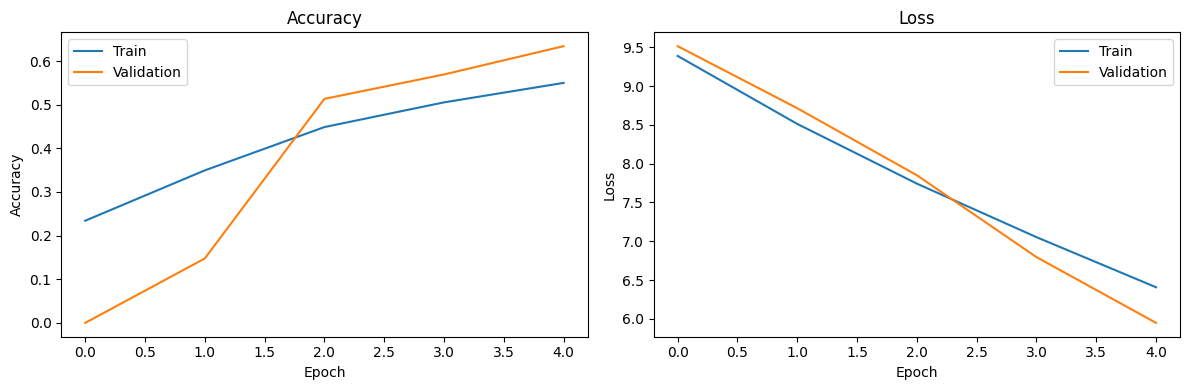

In [13]:
# Visualisation de l'entraînement
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [14]:
# Évaluation
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
print(f"Train accuracy: {train_acc*100:.2f}% | Validation accuracy: {val_acc*100:.2f}%")


Train accuracy: 60.82% | Validation accuracy: 63.42%


In [15]:
# Fonction de prédiction
def predict_emotion(img_path):
    """Prédit l'émotion d'une image"""
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=COLOR_MODE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = int(np.argmax(preds))
    confidence = float(preds[class_idx])
    emotion = label_dict[class_idx]
    
    plt.imshow(img, cmap="gray" if COLOR_MODE == "grayscale" else None)
    plt.axis("off")
    plt.title(f"{emotion} ({confidence*100:.2f}%)")
    plt.show()
    
    print(f"Émotion: {emotion} | Confiance: {confidence*100:.2f}%")
    return emotion, confidence

# Exemple d'utilisation
# predict_emotion("../dataset/test/happy/im1021.png")


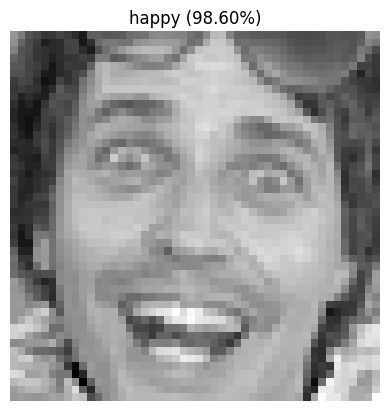

Émotion: happy | Confiance: 98.60%


('happy', 0.9859502911567688)

In [16]:
# Test de prédiction sur une image
img_path = "../dataset/test/happy/im1021.png"
predict_emotion(img_path)

In [17]:
# Charger un modèle sauvegardé (si nécessaire)
if not 'model' in locals():
    if Path(SAVE_NAME).exists():
        model = load_model(SAVE_NAME)
        print(f"✅ Modèle chargé: {SAVE_NAME}")
    else:
        print(f"⚠️ Modèle non trouvé: {SAVE_NAME}")
